Hunter Bennett | Glass Lab | Kupffer Strains Project | 24 Jan 2023

Notebook to generate Upset plots describing overlap of poised enhancers

### Load packages, set plot parameters

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import upsetplot as upset

Set working directory

In [2]:
workingDirectory = '/home/h1bennet/strains_github/results/Figure2_ATAC/' # user will need to set own wd
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Define custom functions

In [3]:
def read_annotated_peaks(path, filter_sex_unknown=True):
    '''This function imports an annotated homer peak file using
    pandas read_csv function. It also performes common preprocessing steps
    such as placing the peak IDs in the index and filtering so that
    only autosomal peaks are included. Also renames index to peakID.
       
       Accepts:
           path (str): path to expression file
           filter_sex_unkown (bool): filter unknown chromosomes
           and sex chromosomes - focus analysis on autosomal chr.
       
       Returns:
           df (pandas.Dataframe): genes by samples with annotation.
           mat (pandas.DataFrame): genes by samples without annotation.
       '''
    # import functions
    import pandas as pd

    df = pd.read_csv(path, sep='\t', index_col=0)

    # rename index
    df.index.rename('PeakID', inplace=True)
    # rename sample columns so they are shorter (can add .str.split('/').str[-1] to shorten even more
    df = df.rename(
        columns=dict(zip(df.iloc[:, 18:].columns.values,
                         pd.Series(df.iloc[:, 18:].columns.values).str.split(' Tag Count').str[0])))

    
    # filter unknown and sex chromosomes
    autosomes = ['chr1', 'chr2', 'chr3', 'chr4',
                 'chr5', 'chr6', 'chr7', 'chr8',
                 'chr9', 'chr10', 'chr11', 'chr12',
                 'chr13', 'chr14', 'chr15', 'chr16',
                 'chr17', 'chr18', 'chr19']

    df = df.loc[df.Chr.str.contains('|'.join(autosomes)), :]
      
    mat = df.iloc[:, 18:]
        
    return (df, mat)

In [4]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

Read in annotation files

In [6]:
# import annotation file
df, mat = read_annotated_peaks('./idr_peaks_atac_norm.txt')

### Generate UpSet plot summarizing overlap of poised enhancers in each group

In [7]:
groups = ['AJ', 'BALBcJ', 'C57Bl6J']
columns = [mat.columns.str.contains('AJ_Kupffer_Control'),
           mat.columns.str.contains('BALBcJ_Kupffer_Control'),
           mat.columns.str.contains('C57_Kupffer_Control')]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

Filter low tag peaks.  
Require at least one group to have an average tag count above minimum threshold, in this case 2^4

In [8]:
thresh=16

peak_dict = {}
for col in avg_tags_df.columns:
    peak_dict[col] = avg_tags_df.index[avg_tags_df[col]>thresh].tolist()

Text(0.5, 1.0, 'Accessible Enhancers')

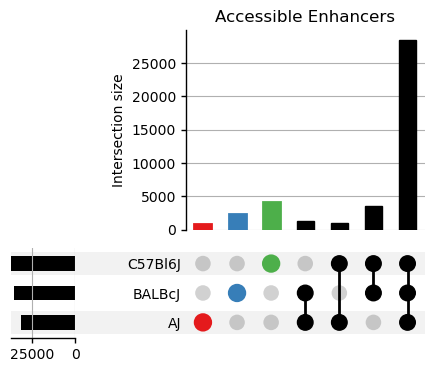

In [9]:

peak_list_upset = upset.from_contents(peak_dict)
p = upset.UpSet(peak_list_upset, orientation="horizontal", sort_categories_by='input')
p.style_subsets(present=["AJ"], absent=["BALBcJ", "C57Bl6J"], facecolor="#e41a1c",
                    linewidth=2)
p.style_subsets(present=["BALBcJ"], absent=["AJ", "C57Bl6J"], facecolor="#377eb8",
                    linewidth=2)
p.style_subsets(present=["C57Bl6J"], absent=["BALBcJ", "AJ"], facecolor="#4daf4a",
                    linewidth=2)
p.plot()
plt.gca().set_title("Accessible Enhancers")